# NetColoc analysis of rare variants in Autism spectrum disorder (ASD) and Congenital Heart Disease (CHD)

Example of NetColoc workflow on genes associated with rare exome variants in ASD and CHD

**Some background:**

Here we introduce NetColoc, a tool which evaluates the extent to which two gene sets are related in network space, i.e. the extent to which they are colocalized in a molecular interaction network, and interrogates the underlying biological pathways and processes using multiscale community detection. This framework may be applied to any number of scenarios in which gene sets have been associated with a phenotype or condition, including rare and common variants within the same disease, genes associated with two comorbid diseases, genetically correlated GWAS phenotypes, GWAS across two different species, or gene expression changes after treatment with two different drugs, to name a few. NetColoc relies on a dual network propagation approach to identify the region of network space which is significantly proximal to both input gene sets, and as such is highly effective for small to medium input gene sets.



# _Obtain input gene sets and interactome_

### 1. Load required packages

In [1]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [4]:

# verify DDOT was installed
import ddot

# from netcoloc import netprop_zscore
# from netcoloc import netprop
# from netcoloc import network_colocalization
# from netcoloc import validation

import sys
sys.path.append('../netcoloc/')
import netprop_zscore
import netprop
import network_colocalization
import validation


In [35]:
import imp

imp.reload(network_colocalization)

<module 'network_colocalization' from '../netcoloc/network_colocalization.py'>

### 2. Select two gene sets of interest. Load gene sets from text files into python.


Identify two gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. 

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [5]:
# set names of geneset 1 and geneset 2
# ------ customize this section based on your gene sets and how they should be labeled -------
d1_name='ASD'
d2_name='CHD'

In [6]:

# ------ customize this section based your input genesets -------

# load rare variants Satterstrom et al 2020; PMID: 31981491

D1_df = pd.read_csv('data/Satterstrom--Top-102-ASD-genes--May2019.csv')
D1_df.index = D1_df['gene']
print('number '+d1_name+' genes:')
print(len(D1_df))
D1_genes = D1_df.index.tolist() # define rare variant genes to seed network propagation
print(D1_genes[0:5])

number ASD genes:
102
['CHD8', 'SCN2A', 'SYNGAP1', 'ADNP', 'FOXP1']


In [7]:
# ------ customize this section based your input genesets -------

# load D2 rare variant genes from Jin et al 2017; PMID: 28991257
D2_df = pd.read_csv('data/CHD_HC.tsv',sep='\t')

D2_genes = D2_df['0'].tolist()
print('number '+d2_name+' genes:')
print(len(D2_genes))
print(D2_genes[0:5])

number CHD genes:
66
['KMT2D', 'CHD7', 'PTPN11', 'NSD1', 'NOTCH1']


In [8]:
# Output the overlap between the two gene sets
print('number of '+d1_name+' and '+d2_name+' genes overlapping:')
print(len(np.intersect1d(D1_genes,D2_genes)))

number of ASD and CHD genes overlapping:
6


### 3. Select molecular interaction network to use for the analysis. 

Identify network UUID on  Ndex (Pratt et al. 2015) and use this to import to jupyter notebook. 

**Usage note**: PCnet is a general purpose interactome, a good starting place https://www.sciencedirect.com/science/article/pii/S2405471218300954.

We recommend switching to “STRING high confidence” if using a machine with low memory.

In [9]:

interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

number of nodes:
18820

number of edges:
2693109


In [10]:
int_nodes = list(G_int.nodes)

# _Identify network colocalized gene network_

### 4. Precalculate matrices needed for propagation. This step should take a few minutes 

Network propagation from genes on selected interactome
- Control for degree of input genes
- Generate a proximity z-score, which defines genes which are closer to input set than expected by chance.
- Repeat for rare and common variant genes, defined above

Background on network propagation: https://www.nature.com/articles/nrg.2017.38.pdf?origin=ppub


In [11]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)


calculating w_prime

calculating w_double_prime


### 5. Subset seed genes to those found in the selected interactome.

In [12]:
# subset seed genes to those found in interactome
print(len(D1_genes))
D1_genes = list(np.intersect1d(D1_genes,int_nodes))
print(len(D1_genes))

print(len(D2_genes))
D2_genes = list(np.intersect1d(D2_genes,int_nodes))
print(len(D2_genes))


102
96
66
60


### 6. Compute network proximity scores from both seed gene sets independently. Network proximity scores correct for the degree distribution of the input gene sets.

In [13]:
# D1 network propagation
print('\nCalculating D1 variant z-scores: ')
z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D1_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D1 = pd.DataFrame({'z':z_D1})

z_D1.sort_values('z',ascending=False).head()


Calculating D1 variant z-scores: 


,z
TRIP12,23.674264
NUP155,20.643715
ADNP,20.489814
TLK2,19.532815
CREBBP,18.945873


In [14]:
# D2 variant network propagation
print('\nCalculating D2 variant z-scores: ')
z_D2, Fnew_D2, Fnew_rand_D2 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D2_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D2 = pd.DataFrame({'z':z_D2})
z_D2.sort_values('z',ascending=False).head()


Calculating D2 variant z-scores: 


,z
ACTB,25.046474
RPL5,24.320330
SMAD2,22.308273
U2SURP,22.132597
NAA15,20.724822


### 7. Compute the network colocalization enrichment for gene set pair. If gene sets are significantly colocalized, proceed with analysis. 


Size of network co-localization subnetwork compared to null model created by permuting individual propagation z-scores. 


In [27]:


seed_dict = {d1_name:D1_genes,d2_name:D2_genes}
# --------------------------------------------------------------------------------------------

zthresh=3

z_d1d2_size, high_z_rand = network_colocalization.calculate_expected_overlap(
    z_D1['z'],
    z_D2['z'],
    plot=False,
    num_reps=100,
    z_score_threshold=zthresh,
    z1_threshold=1.5,
    z2_threshold=1.5
)

ztemp = (z_d1d2_size - np.mean(high_z_rand)) / np.std(high_z_rand)
ptemp = norm.sf(ztemp)
print(d1_name + ' + ' + d2_name)
print('size of network intersection = ' + str(z_d1d2_size))
obs_exp_temp = float(z_d1d2_size) / np.mean(high_z_rand)
print('observed size/ expected size = ' + str(obs_exp_temp))
print('p = ' + str(ptemp))

# save the number of overlapping genes and overlap p-value
network_num_overlap = z_d1d2_size
network_pval_overlap = ptemp
network_obs_exp = obs_exp_temp
network_exp_mean_overlap = np.mean(high_z_rand)
network_exp_std_overlap = np.std(high_z_rand)


ASD + CHD
size of network intersection = 773
observed size/ expected size = 3.0109453511471194
p = 0.0


### 8. Plot the sizes of the observed and expected NetColoc subnetworks.

(-1, 2)

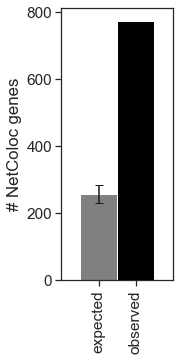

In [28]:
# plot the observed and expected overlaps
plt.figure(figsize=(2,5))
plt.bar([0,1],[network_exp_mean_overlap,network_num_overlap],color=['gray','black'],width=1)
plt.errorbar([0],[network_exp_mean_overlap],[2*network_exp_std_overlap],color='k',capsize=4)
plt.ylabel('# NetColoc genes')
plt.xticks([0,1],['expected','observed'],rotation='vertical')
plt.xlim([-1,2])




### 9. Compute network colocalization subnetwork.

In [29]:
# select the genes in the network intersection, make a subgraph

G_overlap = network_colocalization.calculate_network_overlap_subgraph(G_int,z_D1['z'],z_D2['z'],z_score_threshold=zthresh,
                                                                     z1_threshold=1.5,z2_threshold=1.5)
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))

773
26351


### 10. Transform NetColoc subnetwork edges to cosine similarities

Cosine similarity transformation (and network transformations in general) provide better visualization of clusters


In [18]:
G_cosSim=network_colocalization.transform_edges(G_overlap,method='cosine_sim',edge_weight_threshold=0.95)

../netcoloc/network_colocalization.py:276: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sim_rank.values[[np.arange(sim_rank.shape[0])]*2] = 0


# _Compute network colocalized systems map_

### 11. Convert network colocalization subnetwork to form used in community detection module

In [19]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_overlap.nodes))
node_df['d1_seeds']=0
node_df['d2_seeds']=0
node_df['d1_seeds'].loc[list(np.intersect1d(seed_dict[d1_name],node_df.index.tolist()))]=1
node_df['d2_seeds'].loc[list(np.intersect1d(seed_dict[d2_name],node_df.index.tolist()))]=1
node_df['z_d1']=z_D1.loc[list(G_overlap.nodes)]['z']
node_df['z_d2']=z_D2.loc[list(G_overlap.nodes)]['z']
node_df['z_both']=node_df['z_d1']*node_df['z_d2']
node_df['d1_name']=d1_name
node_df['d2_name']=d2_name
node_df['sum_seeds']=node_df['d1_seeds']+node_df['d2_seeds']

node_df = node_df.sort_values('z_both',ascending=False)
node_df.head(15)

,d1_seeds,d2_seeds,z_d1,z_d2,z_both,d1_name,d2_name,sum_seeds
PTEN,1,1,17.775818,18.270646,324.775666,ASD,CHD,2
CTNNB1,1,1,15.369891,16.212593,249.185790,ASD,CHD,2
POGZ,1,1,12.518539,13.035299,163.182897,ASD,CHD,2
KMT2C,1,1,12.964197,12.579514,163.083297,ASD,CHD,2
NSD1,1,1,12.263667,12.748115,156.338630,ASD,CHD,2
KDM5B,1,1,12.795978,11.553692,147.840781,ASD,CHD,2
CHD4,0,1,4.485093,17.863170,80.117979,ASD,CHD,1
KMT2A,0,1,4.267999,16.113881,68.774032,ASD,CHD,1
CDK13,0,1,4.335774,15.374536,66.660517,ASD,CHD,1
KDM5A,0,1,4.980719,13.264934,66.068913,ASD,CHD,1


### 12. Run community detection on NetColoc subnetwork (recommend HiDef).

Documentation for CDAPS utils to build multiscale systems map in notebook

https://cdapsutil.readthedocs.io/en/latest/quicktutorial.html#example  
https://cdapsutil.readthedocs.io/en/latest/cdapsutil.html#community-detection  

In [20]:
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_overlap_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})

773
26351


In [21]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_ASD_CHD_NetColoc_subgraph
# nodes: 81
# edges: 85


In [22]:
# sr = cdapsutil.ServiceRunner()
# sr.get_algorithms() # this will print out available options for each algorithm

### 13. Convert the NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in Python.


In [23]:
G_hier = G_hier.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print the number of nodes and edges in the hierarchy for diagnostic purposes
print('number of nodes:')
print(len(G_hier.nodes()))
print('\nnumber of edges:')
print(len(G_hier.edges()))

number of nodes:
81

number of edges:
85


In [24]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID
0,KAT8 ATXN1 NF1 KCNIP1 CDC14A ARID4B PRR20A SLC...,770,False,9.589,,,0,0.0,0.0,130,C773,C773,0
1,KAT8 PRDM2 GLI2 SOX4 SMARCB1 SMARCD1 GATAD2A F...,273,False,8.093,,,0,0.0,0.0,6,C774,C774,1
2,ZNF652 ATXN1 CHD9 DYRK1A CDC14A TNRC6A ATXN2 D...,241,False,7.913,,,0,0.0,0.0,13,C775,C775,2
3,PPP3R1 CACNA1B KCNIP1 AFF3 SLC8A2 CACNA1A KCNQ...,165,False,7.366,,,0,0.0,0.0,86,C777,C777,3
4,ATXN1 GLI2 SOX4 PRR20A ZEB2 FOXO1 KLF4 CCDC125...,109,False,6.768,,,0,0.0,0.0,12,C779,C779,4


### 14. Remove systems with no seed genes (optional)

In [30]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds, num_d2_seeds, num_both_seeds = [],[],[]
frac_d1_seeds, frac_d2_seeds, frac_both_seeds=[],[],[]

systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    d1_temp = list(np.intersect1d(system_genes,seed_dict[d1_name]))
    d2_temp = list(np.intersect1d(system_genes,seed_dict[d2_name]))
    num_d1_temp = len(d1_temp)
    num_d2_temp = len(d2_temp)
    if (num_d1_temp+num_d2_temp)>0: # keep the system if it has at least 1 seed gene
        systems_keep.append(c)
        num_both_temp = len(np.intersect1d(d1_temp,d2_temp))
        num_both_seeds.append(num_both_temp)
        num_d1_seeds.append(num_d1_temp-num_both_temp)
        num_d2_seeds.append(num_d2_temp-num_both_temp)
        
        frac_both_seeds.append(num_both_temp/np.float(len(system_genes)))
        frac_d1_seeds.append((num_d1_temp-num_both_temp)/np.float(len(system_genes)))
        frac_d2_seeds.append((num_d2_temp-num_both_temp)/np.float(len(system_genes)))

        
frac_no_seeds = np.subtract(1.0,np.array([frac_d1_seeds,frac_d2_seeds,frac_both_seeds]).sum(axis=0))

hier_df = hier_df.loc[systems_keep]
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['num_d2_seeds']=num_d2_seeds
hier_df['num_both_seeds']=num_d2_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_d2_seeds']=frac_d2_seeds
hier_df['frac_both_seeds']=frac_both_seeds
hier_df['frac_no_seeds']=frac_no_seeds
print(len(hier_df))

hier_df.head()
    

42


,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID,num_d1_seeds,num_d2_seeds,num_both_seeds,frac_d1_seeds,frac_d2_seeds,frac_both_seeds,frac_no_seeds
name,,,,,,,,,,,,,,,,,,,,
C773,KAT8 ATXN1 NF1 KCNIP1 CDC14A ARID4B PRR20A SLC...,770,False,9.589,,,0,0.0,0.0,130,C773,C773,0,41,23,23,0.053247,0.029870,0.007792,0.909091
C774,KAT8 PRDM2 GLI2 SOX4 SMARCB1 SMARCD1 GATAD2A F...,273,False,8.093,,,0,0.0,0.0,6,C774,C774,1,16,7,7,0.058608,0.025641,0.014652,0.901099
C775,ZNF652 ATXN1 CHD9 DYRK1A CDC14A TNRC6A ATXN2 D...,241,False,7.913,,,0,0.0,0.0,13,C775,C775,2,9,7,7,0.037344,0.029046,0.008299,0.925311
C777,PPP3R1 CACNA1B KCNIP1 AFF3 SLC8A2 CACNA1A KCNQ...,165,False,7.366,,,0,0.0,0.0,86,C777,C777,3,12,6,6,0.072727,0.036364,0.000000,0.890909
C779,ATXN1 GLI2 SOX4 PRR20A ZEB2 FOXO1 KLF4 CCDC125...,109,False,6.768,,,0,0.0,0.0,12,C779,C779,4,6,5,5,0.055046,0.045872,0.009174,0.889908


In [31]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print(len(G_hier.nodes()))
print(len(G_hier.edges()))

42
43


In [36]:
# OPTIONAL: sneak peak of hierarchy visualization.
network_colocalization.view_G_hier(G_hier)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

### 15. Annotate systems with gprofiler. 

Annotate moderately sized systems (between 50 to 1000 genes per system) if they are significantly enriched for a Gene Ontology biological process. Also require that the GO term is enriched with p<1E-5 and shares at least 3 genes with the system to annotate, to increase the stringency of the annotation. Label the system using the GO term that meets these criteria, and has the highest sum of precision and recall. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.


In [26]:
# gprofiler annotation of clusters

# hier_df = hier_df.sort_values('name')

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

C773
770


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
8,PKMTs methylate histone lysines,10760,26,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.000039e-16,[REAC:R-HSA-3247509],0.059633,query_1,436,0.366197,True,REAC,71
0,Chromatin organization,10760,91,Chromatin organization,REAC:R-HSA-4839726,2.050576e-57,[REAC:0000000],0.208716,query_1,436,0.333333,True,REAC,273
1,Chromatin modifying enzymes,10760,91,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.050576e-57,[REAC:R-HSA-4839726],0.208716,query_1,436,0.333333,True,REAC,273
16,Transcriptional Regulation by MECP2,10760,18,Transcriptional Regulation by MECP2,REAC:R-HSA-8986944,4.578284e-10,[REAC:R-HSA-212436],0.041284,query_1,436,0.305085,True,REAC,59
22,Ion homeostasis,10760,16,Ion homeostasis,REAC:R-HSA-5578775,7.783190e-09,[REAC:R-HSA-5576891],0.036697,query_1,436,0.296296,True,REAC,54


C774
273


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
5,PKMTs methylate histone lysines,10760,22,PKMTs methylate histone lysines,REAC:R-HSA-3214841,7.858450e-22,[REAC:R-HSA-3247509],0.136646,query_1,161,0.309859,True,REAC,71
0,Chromatin modifying enzymes,10760,72,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.681332e-71,[REAC:R-HSA-4839726],0.447205,query_1,161,0.263736,True,REAC,273
1,Chromatin organization,10760,72,Chromatin organization,REAC:R-HSA-4839726,1.681332e-71,[REAC:0000000],0.447205,query_1,161,0.263736,True,REAC,273
17,Regulation of PTEN gene transcription,10760,12,Regulation of PTEN gene transcription,REAC:R-HSA-8943724,1.226600e-09,[REAC:R-HSA-6807070],0.074534,query_1,161,0.203390,True,REAC,59
18,Formation of the beta-catenin:TCF transactivat...,10760,13,Formation of the beta-catenin:TCF transactivat...,REAC:R-HSA-201722,1.851030e-08,[REAC:R-HSA-201681],0.080745,query_1,161,0.142857,True,REAC,91


C775
241


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Chromatin modifying enzymes,10760,19,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.957292e-08,[REAC:R-HSA-4839726],0.157025,query_1,121,0.069597,True,REAC,273
1,Chromatin organization,10760,19,Chromatin organization,REAC:R-HSA-4839726,4.957292e-08,[REAC:0000000],0.157025,query_1,121,0.069597,True,REAC,273


C777
165


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
7,Ion homeostasis,10760,16,Ion homeostasis,REAC:R-HSA-5578775,1.018806e-17,[REAC:R-HSA-5576891],0.133333,query_1,120,0.296296,True,REAC,54
11,NCAM signaling for neurite out-growth,10760,15,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,1.241364e-15,[REAC:R-HSA-422475],0.125000,query_1,120,0.254237,True,REAC,59
1,Cardiac conduction,10760,31,Cardiac conduction,REAC:R-HSA-5576891,9.973893e-32,[REAC:R-HSA-397014],0.258333,query_1,120,0.244094,True,REAC,127
4,L1CAM interactions,10760,27,L1CAM interactions,REAC:R-HSA-373760,8.436880e-27,[REAC:R-HSA-422475],0.225000,query_1,120,0.226891,True,REAC,119
20,Ion transport by P-type ATPases,10760,10,Ion transport by P-type ATPases,REAC:R-HSA-936837,5.001956e-09,[REAC:R-HSA-983712],0.083333,query_1,120,0.181818,True,REAC,55


C779
109


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
5,Transcriptional regulation by RUNX3,10760,10,Transcriptional regulation by RUNX3,REAC:R-HSA-8878159,4.139018e-09,[REAC:R-HSA-212436],0.169492,query_1,59,0.106383,True,REAC,94
17,FOXO-mediated transcription,10760,7,FOXO-mediated transcription,REAC:R-HSA-9614085,1.230245e-06,[REAC:R-HSA-212436],0.118644,query_1,59,0.106061,True,REAC,66
24,Signaling by NOTCH1 HD+PEST Domain Mutants in ...,10760,6,Signaling by NOTCH1 HD+PEST Domain Mutants in ...,REAC:R-HSA-2894858,7.472392e-06,[REAC:R-HSA-2644603],0.101695,query_1,59,0.105263,True,REAC,57
25,Signaling by NOTCH1 PEST Domain Mutants in Cancer,10760,6,Signaling by NOTCH1 PEST Domain Mutants in Cancer,REAC:R-HSA-2644602,7.472392e-06,[REAC:R-HSA-2644603],0.101695,query_1,59,0.105263,True,REAC,57
26,Signaling by NOTCH1 in Cancer,10760,6,Signaling by NOTCH1 in Cancer,REAC:R-HSA-2644603,7.472392e-06,[REAC:R-HSA-5663202],0.101695,query_1,59,0.105263,True,REAC,57


C787
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C802
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C804
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C815
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C816
6


""


C830
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C836
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C778
160


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,PKMTs methylate histone lysines,10760,20,PKMTs methylate histone lysines,REAC:R-HSA-3214841,5.685580e-23,[REAC:R-HSA-3247509],0.196078,query_1,102,0.281690,True,REAC,71
0,Chromatin modifying enzymes,10760,66,Chromatin modifying enzymes,REAC:R-HSA-3247509,3.075648e-80,[REAC:R-HSA-4839726],0.647059,query_1,102,0.241758,True,REAC,273
1,Chromatin organization,10760,66,Chromatin organization,REAC:R-HSA-4839726,3.075648e-80,[REAC:0000000],0.647059,query_1,102,0.241758,True,REAC,273
12,Regulation of PTEN gene transcription,10760,11,Regulation of PTEN gene transcription,REAC:R-HSA-8943724,1.132230e-10,[REAC:R-HSA-6807070],0.107843,query_1,102,0.186441,True,REAC,59
14,RMTs methylate histone arginines,10760,11,RMTs methylate histone arginines,REAC:R-HSA-3214858,2.615019e-09,[REAC:R-HSA-3247509],0.107843,query_1,102,0.139241,True,REAC,79


C824
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C797
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C806
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C776
173


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C842
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C812
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C849
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C800
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Axon guidance,10760,5,Axon guidance,REAC:R-HSA-422475,0.000003,[REAC:R-HSA-9675108],1.0,query_1,5,0.009107,True,REAC,549
2,Nervous system development,10760,5,Nervous system development,REAC:R-HSA-9675108,0.000003,[REAC:R-HSA-1266738],1.0,query_1,5,0.008711,True,REAC,574


C807
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C808
7


""


C780
45


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
5,Ion homeostasis,10760,10,Ion homeostasis,REAC:R-HSA-5578775,6.719806e-14,[REAC:R-HSA-5576891],0.256410,query_1,39,0.185185,True,REAC,54
17,NCAM signaling for neurite out-growth,10760,7,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,1.139110e-08,[REAC:R-HSA-422475],0.179487,query_1,39,0.118644,True,REAC,59
14,Post NMDA receptor activation events,10760,8,Post NMDA receptor activation events,REAC:R-HSA-438064,2.162220e-09,[REAC:R-HSA-442755],0.205128,query_1,39,0.105263,True,REAC,76
6,Cardiac conduction,10760,12,Cardiac conduction,REAC:R-HSA-5576891,2.721001e-13,[REAC:R-HSA-397014],0.307692,query_1,39,0.094488,True,REAC,127
15,Activation of NMDA receptors and postsynaptic ...,10760,8,Activation of NMDA receptors and postsynaptic ...,REAC:R-HSA-442755,7.342460e-09,[REAC:R-HSA-112314],0.205128,query_1,39,0.089888,True,REAC,89


C783
24


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10760,19,L1CAM interactions,REAC:R-HSA-373760,7.029448e-36,[REAC:R-HSA-422475],0.95,query_1,20,0.159664,True,REAC,119
11,NCAM signaling for neurite out-growth,10760,5,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,2.377398e-07,[REAC:R-HSA-422475],0.25,query_1,20,0.084746,True,REAC,59
6,Cardiac conduction,10760,10,Cardiac conduction,REAC:R-HSA-5576891,4.114095e-14,[REAC:R-HSA-397014],0.50,query_1,20,0.078740,True,REAC,127
8,COPI-mediated anterograde transport,10760,7,COPI-mediated anterograde transport,REAC:R-HSA-6807878,2.043872e-09,[REAC:R-HSA-199977],0.35,query_1,20,0.068627,True,REAC,102
7,Muscle contraction,10760,10,Muscle contraction,REAC:R-HSA-397014,2.813778e-12,[REAC:0000000],0.50,query_1,20,0.051282,True,REAC,195


C790
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Potassium Channels,10760,8,Potassium Channels,REAC:R-HSA-1296071,4.489949e-13,[REAC:R-HSA-112316],0.666667,query_1,12,0.077670,True,REAC,103
3,Ion homeostasis,10760,4,Ion homeostasis,REAC:R-HSA-5578775,2.053675e-06,[REAC:R-HSA-5576891],0.333333,query_1,12,0.074074,True,REAC,54
4,Ion transport by P-type ATPases,10760,4,Ion transport by P-type ATPases,REAC:R-HSA-936837,2.053675e-06,[REAC:R-HSA-983712],0.333333,query_1,12,0.072727,True,REAC,55
5,Potential therapeutics for SARS,10760,4,Potential therapeutics for SARS,REAC:R-HSA-9679191,7.432187e-06,[REAC:R-HSA-9679506],0.333333,query_1,12,0.050633,True,REAC,79
2,Neuronal System,10760,8,Neuronal System,REAC:R-HSA-112316,1.725326e-08,[REAC:0000000],0.666667,query_1,12,0.020000,True,REAC,400


C809
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Formation of the beta-catenin:TCF transactivat...,10760,4,Formation of the beta-catenin:TCF transactivat...,REAC:R-HSA-201722,0.000003,[REAC:R-HSA-201681],0.571429,query_1,7,0.043956,True,REAC,91


C781
28


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Chromatin modifying enzymes,10760,13,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.336325e-17,[REAC:R-HSA-4839726],0.764706,query_1,17,0.047619,True,REAC,273
2,Chromatin organization,10760,13,Chromatin organization,REAC:R-HSA-4839726,4.336325e-17,[REAC:0000000],0.764706,query_1,17,0.047619,True,REAC,273


C782
26


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,HATs acetylate histones,10760,8,HATs acetylate histones,REAC:R-HSA-3214847,1.618866e-11,[REAC:R-HSA-3247509],0.615385,query_1,13,0.056738,True,REAC,141
0,Chromatin modifying enzymes,10760,10,Chromatin modifying enzymes,REAC:R-HSA-3247509,7.032522e-13,[REAC:R-HSA-4839726],0.769231,query_1,13,0.036630,True,REAC,273
1,Chromatin organization,10760,10,Chromatin organization,REAC:R-HSA-4839726,7.032522e-13,[REAC:0000000],0.769231,query_1,13,0.036630,True,REAC,273
4,Regulation of TP53 Activity,10760,5,Regulation of TP53 Activity,REAC:R-HSA-5633007,8.941243e-06,[REAC:R-HSA-3700989],0.384615,query_1,13,0.031250,True,REAC,160


C784
24


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10760,14,PKMTs methylate histone lysines,REAC:R-HSA-3214841,2.135571e-27,[REAC:R-HSA-3247509],0.823529,query_1,17,0.197183,True,REAC,71
1,Chromatin modifying enzymes,10760,14,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.926591e-19,[REAC:R-HSA-4839726],0.823529,query_1,17,0.051282,True,REAC,273
2,Chromatin organization,10760,14,Chromatin organization,REAC:R-HSA-4839726,2.926591e-19,[REAC:0000000],0.823529,query_1,17,0.051282,True,REAC,273


C811
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C786
17


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,NCAM signaling for neurite out-growth,10760,7,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,1.796844e-11,[REAC:R-HSA-422475],0.466667,query_1,15,0.118644,True,REAC,59
4,Regulation of insulin secretion,10760,5,Regulation of insulin secretion,REAC:R-HSA-422356,5.587045e-07,[REAC:R-HSA-163685],0.333333,query_1,15,0.064103,True,REAC,78
6,Integration of energy metabolism,10760,5,Integration of energy metabolism,REAC:R-HSA-163685,1.964719e-06,[REAC:R-HSA-1430728],0.333333,query_1,15,0.046729,True,REAC,107
5,Axon guidance,10760,8,Axon guidance,REAC:R-HSA-422475,1.908358e-06,[REAC:R-HSA-9675108],0.533333,query_1,15,0.014572,True,REAC,549
7,Nervous system development,10760,8,Nervous system development,REAC:R-HSA-9675108,2.017669e-06,[REAC:R-HSA-1266738],0.533333,query_1,15,0.013937,True,REAC,574


C789
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Chromatin modifying enzymes,10760,6,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.673849e-08,[REAC:R-HSA-4839726],0.857143,query_1,7,0.021978,True,REAC,273
2,Chromatin organization,10760,6,Chromatin organization,REAC:R-HSA-4839726,1.673849e-08,[REAC:0000000],0.857143,query_1,7,0.021978,True,REAC,273


C795
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C791
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HATs acetylate histones,10760,5,HATs acetylate histones,REAC:R-HSA-3214847,5.129389e-08,[REAC:R-HSA-3247509],0.833333,query_1,6,0.035461,True,REAC,141
1,Chromatin modifying enzymes,10760,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.767461e-07,[REAC:R-HSA-4839726],0.833333,query_1,6,0.018315,True,REAC,273
2,Chromatin organization,10760,5,Chromatin organization,REAC:R-HSA-4839726,4.767461e-07,[REAC:0000000],0.833333,query_1,6,0.018315,True,REAC,273


C785
18


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10760,15,L1CAM interactions,REAC:R-HSA-373760,4.621190e-28,[REAC:R-HSA-422475],0.9375,query_1,16,0.126050,True,REAC,119
6,Cardiac conduction,10760,9,Cardiac conduction,REAC:R-HSA-5576891,1.628274e-13,[REAC:R-HSA-397014],0.5625,query_1,16,0.070866,True,REAC,127
7,Muscle contraction,10760,9,Muscle contraction,REAC:R-HSA-397014,7.192419e-12,[REAC:0000000],0.5625,query_1,16,0.046154,True,REAC,195
3,Axon guidance,10760,15,Axon guidance,REAC:R-HSA-422475,4.200753e-18,[REAC:R-HSA-9675108],0.9375,query_1,16,0.027322,True,REAC,549
4,Nervous system development,10760,15,Nervous system development,REAC:R-HSA-9675108,6.594728e-18,[REAC:R-HSA-1266738],0.9375,query_1,16,0.026132,True,REAC,574


C792
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10760,5,PKMTs methylate histone lysines,REAC:R-HSA-3214841,9.061168e-10,[REAC:R-HSA-3247509],0.833333,query_1,6,0.070423,True,REAC,71
1,Chromatin modifying enzymes,10760,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.781019e-07,[REAC:R-HSA-4839726],0.833333,query_1,6,0.018315,True,REAC,273
2,Chromatin organization,10760,5,Chromatin organization,REAC:R-HSA-4839726,2.781019e-07,[REAC:0000000],0.833333,query_1,6,0.018315,True,REAC,273


C803
7


""


C805
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HATs acetylate histones,10760,4,HATs acetylate histones,REAC:R-HSA-3214847,2.826403e-07,[REAC:R-HSA-3247509],1.0,query_1,4,0.028369,True,REAC,141
1,Chromatin modifying enzymes,10760,4,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.351875e-06,[REAC:R-HSA-4839726],1.0,query_1,4,0.014652,True,REAC,273
2,Chromatin organization,10760,4,Chromatin organization,REAC:R-HSA-4839726,1.351875e-06,[REAC:0000000],1.0,query_1,4,0.014652,True,REAC,273


C813
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C841
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C853
4


""


# _Validate identified genes and systems_

### 16. Load and parse mouse knockout database

Requires DDOT for ontology parsing https://github.com/michaelkyu/ddot/blob/master/examples/Tutorial.ipynb

Parse the ontology, data from http://www.informatics.jax.org/vocab/mp_ontology


In [27]:
mgi_df = validation.load_MGI_mouseKO_data()
mgi_df.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24218...done.
Finished.
38 input query terms found dup hits:
	[('Abo', 3), ('Adam1a', 2), ('Adam1b', 2), ('Adam5', 2), ('Casp12', 2), ('Ccdc39', 2), ('Chaserr', 2
12302 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name,human_ortholog
gene_name,,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1,RB1


In [28]:
MPO = validation.load_MPO()
MPO

14642


,description
MP,
MP:0000001,mammalian phenotype
MP:0000002,obsolete Morphology
MP:0000003,abnormal adipose tissue morphology
MP:0000011,abnormal adipose tissue morphology
MP:0000005,increased brown adipose tissue amount


,Parent,Child,Relation,Namespace
0,MP:0005375,MP:0000003,is_a,MPheno.ontology
1,MP:0001778,MP:0000005,is_a,MPheno.ontology
2,MP:0001781,MP:0000008,is_a,MPheno.ontology
3,MP:0005334,MP:0000010,is_a,MPheno.ontology
4,MP:0000003,MP:0000013,is_a,MPheno.ontology


0 genes, 13507 terms, 0 gene-term relations, 17082 term-term relations
node_attributes: ['description']
edge_attributes: ['Relation', 'Namespace']

### 17. Identify phenotype(s) of interest. 

Recommend including a negative control, a phenotype that is not expected to overlap with the two phenotypes of interest.

#### here we find MPO terms related to brain or heart

Modify as needed for each specific project

In [29]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('nervous')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neuron')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('synapt')>-1:
        MP_focal_brain_list.append(t)
        
print(len(MP_focal_brain_list))
print(MP_focal_brain_list[0:10])

200
['MP:0000778', 'MP:0000811', 'MP:0000937', 'MP:0000938', 'MP:0000939', 'MP:0000940', 'MP:0000958', 'MP:0000965', 'MP:0000966', 'MP:0000968']


In [30]:
# find terms related to heart
MP_focal_heart_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('cardi')>-1:
        MP_focal_heart_list.append(t)
    elif descr_temp.find('heart')>-1:
        MP_focal_heart_list.append(t)
        
print(len(MP_focal_heart_list))
print(MP_focal_heart_list[0:10])

285
['MP:0000266', 'MP:0000267', 'MP:0000269', 'MP:0000270', 'MP:0000274', 'MP:0000275', 'MP:0000276', 'MP:0000277', 'MP:0000278', 'MP:0000285']


### 18. Compute the enrichment of selected phenotype(s) in NetColoc subnetwork as a whole.

In [31]:
# add a negative control phenotype: abnormal innate immunity: MP:0008171
# negative controls are tough here because we're dealing with development... which impacts almost everything
MP_focal_list = ['MP:0002419']+MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)



abnormal innate immunity
number of genes in root node = 770
number of genes in focal MPO term = 595
number overlapping genes = 18
0.18402479408491146
(-0.7965580242442405, 0.15296858179876788)
-0.32179472122273634

abnormal nervous system tract morphology
number of genes in root node = 770
number of genes in focal MPO term = 207
number overlapping genes = 28
1.3755355932500275e-10
(0.921375948442648, 1.7314321064850848)
1.3264040274638664

hippocampal neuron degeneration
number of genes in root node = 770
number of genes in focal MPO term = 27
number overlapping genes = 1
0.9189768413841193
(-2.1023314783704885, 1.894875427540397)
-0.10372802541504589

abnormal motor neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 166
number overlapping genes = 12
0.04353131942749682
(0.0177005982411379, 1.2015057315627926)
0.6096031649019653

motor neuron degeneration
number of genes in root node = 770
number of genes in focal MPO term = 43
number overlapping 


abnormal GABAergic neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 29
number overlapping genes = 1
0.8612857732176975
(-2.1739084714041863, 1.8180145376324535)
-0.17794696688586642

loss of GABAergic neurons
number of genes in root node = 770
number of genes in focal MPO term = 12
number overlapping genes = 1
0.4686886847279035
(-1.2910822233877135, 2.80569245819504)
0.7573051174036634

premature neuronal precursor differentiation
number of genes in root node = 770
number of genes in focal MPO term = 22
number overlapping genes = 3
0.035084862207620124
(0.091743408296727, 2.5313251635248353)
1.311534285910781

abnormal synaptic transmission
number of genes in root node = 770
number of genes in focal MPO term = 948
number overlapping genes = 94
5.005075919578527e-19
(0.803172021200307, 1.2560331589089755)
1.0296025900546413

abnormal nervous system development
number of genes in root node = 770
number of genes in focal MPO term = 1223
number ove


abnormal neuron differentiation
number of genes in root node = 770
number of genes in focal MPO term = 324
number overlapping genes = 36
9.130359966343597e-10
(0.75261267248081, 1.4611194325673844)
1.1068660525240972

abnormal hippocampus neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 117
number overlapping genes = 16
1.025588650547438e-06
(0.7949801178967065, 1.8597509210007077)
1.327365519448707

abnormal neuron proliferation
number of genes in root node = 770
number of genes in focal MPO term = 124
number overlapping genes = 18
5.60394593816925e-08
(0.8942549828409476, 1.904159849227656)
1.3992074160343018

abnormal sensory neuron physiology
number of genes in root node = 770
number of genes in focal MPO term = 64
number overlapping genes = 9
0.0001816066714732444
(0.6446336515369172, 2.061580857973469)
1.353107254755193

abnormal synaptic dopamine release
number of genes in root node = 770
number of genes in focal MPO term = 14
number over

In [32]:
root_KO_brain_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0002419,1.840248e-01,-0.321795,-0.796558,0.152969,595,abnormal innate immunity
MP:0000778,1.375536e-10,1.326404,0.921376,1.731432,207,abnormal nervous system tract morphology
MP:0000811,9.189768e-01,-0.103728,-2.102331,1.894875,27,hippocampal neuron degeneration
MP:0000937,4.353132e-02,0.609603,0.017701,1.201506,166,abnormal motor neuron morphology
MP:0000938,9.441254e-02,0.880289,-0.151260,1.911837,43,motor neuron degeneration


In [33]:
MP_focal_list = MP_focal_heart_list
root_KO_heart_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)


abnormal heart morphology
number of genes in root node = 770
number of genes in focal MPO term = 1828
number overlapping genes = 155
4.387680941493712e-22
(0.7198668310470243, 1.0862578461045218)
0.903062338575773

abnormal heart development
number of genes in root node = 770
number of genes in focal MPO term = 365
number overlapping genes = 52
6.35277598875199e-20
(1.1091358322322216, 1.7148223501650528)
1.4119790911986372

abnormal heart looping
number of genes in root node = 770
number of genes in focal MPO term = 130
number overlapping genes = 14
0.00022762160292303646
(0.4925928531534196, 1.6111659345292888)
1.0518793938413542

abnormal heart tube morphology
number of genes in root node = 770
number of genes in focal MPO term = 81
number overlapping genes = 12
6.809631925587984e-06
(0.7998738149572542, 2.0345015518027605)
1.4171876833800074

enlarged heart
number of genes in root node = 770
number of genes in focal MPO term = 875
number overlapping genes = 71
1.9099286293933335e-


abnormal cardiac muscle contractility
number of genes in root node = 770
number of genes in focal MPO term = 294
number overlapping genes = 24
0.0005175632747826712
(0.32687982223265977, 1.174591738194751)
0.7507357802137054

increased myocardial infarct size
number of genes in root node = 770
number of genes in focal MPO term = 30
number overlapping genes = 3
0.11547585843475806
(-0.23529026205721792, 2.154675502635877)
0.9596926202893297

decreased myocardial infarct size
number of genes in root node = 770
number of genes in focal MPO term = 25
number overlapping genes = 1
0.981584031002595
(-2.0252556806614352, 1.9781069591869649)
-0.023574360737235178

abnormal epicardium morphology
number of genes in root node = 770
number of genes in focal MPO term = 17
number overlapping genes = 4
0.0005475775877472551
(0.8573609153793458, 3.1033257177965794)
1.9803433165879627

abnormal heart atrium morphology
number of genes in root node = 770
number of genes in focal MPO term = 233
number ov


abnormal heart weight
number of genes in root node = 770
number of genes in focal MPO term = 451
number overlapping genes = 40
4.814276582922469e-07
(0.5221481749839201, 1.1880705131895646)
0.8551093440867423

dilated heart
number of genes in root node = 770
number of genes in focal MPO term = 235
number overlapping genes = 17
0.015962525828510408
(0.11449762628491245, 1.1123082307809642)
0.6134029285329383

decreased cardiac muscle contractility
number of genes in root node = 770
number of genes in focal MPO term = 234
number overlapping genes = 20
0.000743358419815196
(0.33458717456416687, 1.2627272609341353)
0.7986572177491511

hemopericardium
number of genes in root node = 770
number of genes in focal MPO term = 47
number overlapping genes = 4
0.13541832664261494
(-0.24466956101260018, 1.8095254127230833)
0.7824279258552416

abnormal heart ventricle morphology
number of genes in root node = 770
number of genes in focal MPO term = 716
number overlapping genes = 70
5.047750659934877


myocardium hypoplasia
number of genes in root node = 770
number of genes in focal MPO term = 87
number overlapping genes = 16
1.7233013258163005e-09
(1.134205970955401, 2.2287463616782075)
1.6814761663168043

ventricle myocardium hypoplasia
number of genes in root node = 770
number of genes in focal MPO term = 70
number overlapping genes = 14
3.160264671650573e-09
(1.1933035452934846, 2.3736122760617953)
1.7834579106776398

myocardial trabeculae hypoplasia
number of genes in root node = 770
number of genes in focal MPO term = 61
number overlapping genes = 13
3.3019832013601546e-09
(1.245520976426894, 2.4797254934395614)
1.8626232349332277

abnormal heart electrocardiography waveform feature
number of genes in root node = 770
number of genes in focal MPO term = 263
number overlapping genes = 24
5.748600189698738e-05
(0.44840929910194677, 1.3004631032009726)
0.8744362011514597

abnormal heart layer morphology
number of genes in root node = 770
number of genes in focal MPO term = 436
num


decreased susceptibility to myocardial ischemic injury
number of genes in root node = 770
number of genes in focal MPO term = 25
number overlapping genes = 1
0.981584031002595
(-2.0252556806614352, 1.9781069591869649)
-0.023574360737235178

increased susceptibility to myocardial ischemic injury
number of genes in root node = 770
number of genes in focal MPO term = 32
number overlapping genes = 3
0.14382495188045535
(-0.302747571295233, 2.078992932960533)
0.8881226808326499


In [34]:
root_KO_heart_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0000266,4.387681e-22,0.903062,0.719867,1.086258,1828,abnormal heart morphology
MP:0000267,6.352776e-20,1.411979,1.109136,1.714822,365,abnormal heart development
MP:0000269,2.276216e-04,1.051879,0.492593,1.611166,130,abnormal heart looping
MP:0000270,6.809632e-06,1.417188,0.799874,2.034502,81,abnormal heart tube morphology
MP:0000274,1.909929e-09,0.778765,0.524597,1.032933,875,enlarged heart


In [35]:
# join brain and heart results together
root_KO_brain_df['MPO_term_type']='brain'
root_KO_heart_df['MPO_term_type']='heart'
root_KO_df = root_KO_brain_df.append(root_KO_heart_df)
root_KO_df['MPO_term_type'].loc['MP:0002419']='neg_ctrl'
root_KO_df = root_KO_df.sort_values('OR_p')
root_KO_df.head()

/Users/brinrosenthal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description,MPO_term_type
MP:0002882,6.069374e-25,1.000897,0.810704,1.191091,1527,abnormal neuron morphology,brain
MP:0003861,1.311453e-23,1.042576,0.838538,1.246614,1223,abnormal nervous system development,brain
MP:0002925,9.761883e-23,1.181350,0.945431,1.417269,766,abnormal cardiovascular development,heart
MP:0000266,4.387681e-22,0.903062,0.719867,1.086258,1828,abnormal heart morphology,heart
MP:0000267,6.352776e-20,1.411979,1.109136,1.714822,365,abnormal heart development,heart


In [36]:
root_KO_df['MPO_term_type'].value_counts()

heart       155
brain       102
neg_ctrl      1
Name: MPO_term_type, dtype: int64

### plot top performing brain and heart terms + negative control term

In [37]:
# plot top performing brain and heart terms + negative control term (MP:0002419')

# plot 5 best and 5 worst (for terms which have at least 150 genes)

heart_terms_plot = root_KO_heart_df[root_KO_heart_df['num_genes_in_term']>150]
heart_terms_plot = heart_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+heart_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

brain_terms_plot = root_KO_brain_df[root_KO_brain_df['num_genes_in_term']>150]
brain_terms_plot = brain_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+brain_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

neg_ctrl_terms_plot=['MP:0002419']

terms_plot = brain_terms_plot+heart_terms_plot +neg_ctrl_terms_plot



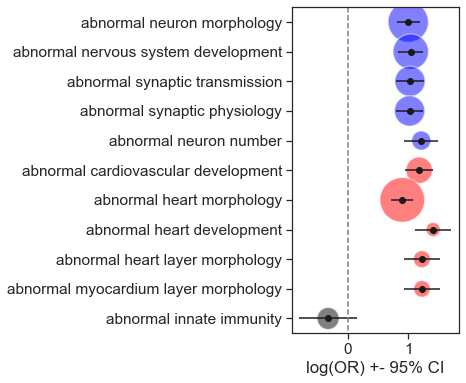

In [38]:
plt.figure(figsize=(3,6))

plt.errorbar(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),
            xerr=[np.subtract(root_KO_df.loc[terms_plot]['log_OR'],root_KO_df.loc[terms_plot]['log_OR_CI_lower']),
                   np.subtract(root_KO_df.loc[terms_plot]['log_OR_CI_upper'],root_KO_df.loc[terms_plot]['log_OR'])],color='k',fmt='o')

color_temp = root_KO_df.loc[terms_plot]['MPO_term_type'].map({'brain':'blue','heart':'red','neg_ctrl':'black'})

sns.scatterplot(x=root_KO_df.loc[terms_plot]['log_OR'],
                y=np.arange(len(terms_plot)),size=root_KO_df.loc[terms_plot]['num_genes_in_term'],sizes=(200, 2000),
                alpha=.5,
               hue=color_temp.tolist(),palette={'blue':'blue','red':'red','black':'black'},legend=False)

plt.yticks(np.arange(len(terms_plot)),root_KO_df.loc[terms_plot]['MP_description'])
plt.xticks([0,1,2])
plt.xlabel('log(OR) +- 95% CI')

plt.plot([0,0],[-.5,len(terms_plot)-.5],'--',color='gray')
plt.ylim([-.5,len(terms_plot)-.5])

plt.gca().invert_yaxis()



# plt.savefig('ASD_CHD_brain_heart_MPO_root_enrichment_210813.png',dpi=300,bbox_inches='tight')



### 19. Compute the enrichment of phenotype(s) in NetColoc subsystems.

In [39]:
MP_focal_top = root_KO_df.head(10).index.tolist() # record the top 10 overall
MP_full_results_df = validation.MPO_enrichment_full(hier_df,MPO,mgi_df,MP_focal_top,G_int)
MP_full_results_df.head()

abnormal neuron morphology
Genes and Terms to keep: 267
abnormal nervous system development
Genes and Terms to keep: 191
abnormal cardiovascular development
Genes and Terms to keep: 139
abnormal heart morphology
Genes and Terms to keep: 369
abnormal heart development
Genes and Terms to keep: 39
abnormal synaptic transmission
Genes and Terms to keep: 73
abnormal synaptic physiology
Genes and Terms to keep: 78
abnormal myocardial trabeculae morphology
Genes and Terms to keep: 7
abnormal neuron number
Genes and Terms to keep: 55
abnormal neuron physiology
Genes and Terms to keep: 47


,abnormal neuron morphology:-log(OR_p),abnormal neuron morphology:log_OR,abnormal neuron morphology:num_genes,abnormal neuron morphology:gene_ids,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal cardiovascular development:-log(OR_p),abnormal cardiovascular development:log_OR,...,abnormal myocardial trabeculae morphology:num_genes,abnormal myocardial trabeculae morphology:gene_ids,abnormal neuron number:-log(OR_p),abnormal neuron number:log_OR,abnormal neuron number:num_genes,abnormal neuron number:gene_ids,abnormal neuron physiology:-log(OR_p),abnormal neuron physiology:log_OR,abnormal neuron physiology:num_genes,abnormal neuron physiology:gene_ids
C773,24.216856,1.000897,142,AFDN AFF1 ANK2 ANK3 ARID1B ATM ATP1A3 ATP1B2 A...,22.882247,1.042576,120,AFDN AGO2 ANKRD17 APC ARHGEF7 ARID1A ARID1B BC...,22.010466,1.181350,...,30,AKAP13 ANKRD17 ARID1A BRAF EP300 EZH2 FGFR2 FO...,16.779147,1.216200,60,AFDN ANK3 ARID1B ATXN1 BRAF BRPF1 CACNA1A CACN...,16.017607,1.114419,68,ARHGEF2 ATM ATP1A3 BRAF BRPF1 CACNA1C CACNA1D ...
C774,4.038199,0.677817,40,ARID1B BCL11A BRD7 BRPF1 CHD7 CLOCK CTNNB1 DNM...,17.883508,1.346338,56,ARID1A ARID1B BCL11A BRD1 BRD2 BRPF1 CHD7 CREB...,21.565175,1.612910,...,14,ARID1A EP300 EZH2 FOXO1 GATA4 JARID2 KDM6A MEF...,6.853507,1.195787,22,ARID1B BRPF1 CHD7 DNMT3A FOXG1 GLI2 HIPK2 HOXA...,4.077623,0.908187,21,ARHGEF2 BRPF1 CHD7 CTNNB1 EHMT2 EPAS1 FOXG1 HI...
C775,2.452646,0.559418,32,AFF1 ATM ATRX ATXN1 ATXN2 BRAF CDC14A CLEC16A ...,4.086781,0.766970,31,AGO2 ANKRD17 APC ARHGEF7 BRAF C2CD3 CDK13 CHD8...,3.448389,0.826373,...,7,AKAP13 ANKRD17 BRAF NFAT5 RBPJ UBR2 WNK1,3.688077,0.975675,16,ATXN1 BRAF CDC14A HERC1 HIVEP2 KIDINS220 LYST ...,0.145740,0.124990,9,ATM BRAF CHD8 CREB1 GSK3B KIDINS220 PTEN SPG7 ...
C777,23.298397,1.707617,53,ANK2 ANK3 ATP1A3 ATP1B2 CACNA1A CACNA1D CACNA1...,2.408068,0.693634,20,CACNA1A CNTN1 CNTN2 DSCAM FGFR2 ISL1 LGI1 MAPT...,2.303976,0.791765,...,7,FGFR2 ISL1 RYR2 SCN5A SLC8A1 SPTBN1 TEK,4.931574,1.240930,14,ANK3 CACNA1A CACNA1D CACNA1F CACNB2 DSCAM DSCA...,15.941473,1.778010,27,ATP1A3 CACNA1C CACNA1D CACNA1F CACNA1G CAMK2A ...
C779,6.336400,1.173314,24,AFDN ATXN1 BCL11A CTNNB1 FOXG1 FOXN4 GLI2 HIPK...,15.732417,1.764932,31,AFDN BCL11A CREBBP CTBP1 CTBP2 CTNNB1 EP300 FO...,21.006499,2.130437,...,8,EP300 FOXO1 GATA4 MEF2C MYCN NOTCH1 NOTCH2 NR2F2,9.662883,1.789096,15,AFDN ATXN1 FOXG1 FOXN4 GLI2 HIPK2 MYCN NOTCH1 ...,5.490926,1.389171,13,CTNNB1 EPAS1 FOXG1 HDAC4 HIPK2 MYCN NCOR2 NOTC...


In [40]:
MP_focal_top

['MP:0002882',
 'MP:0003861',
 'MP:0002925',
 'MP:0000266',
 'MP:0000267',
 'MP:0003635',
 'MP:0021009',
 'MP:0002189',
 'MP:0008946',
 'MP:0004811']

### 20. Annotate the NetColoc Systems Map with mouse knockout data, input genes, and enriched GO terms

In [41]:
# add the best gprofiler annotation
MP_full_results_df['gprofiler_name']=pd.Series(system_name_list,index=hier_df.index.tolist())
# don't annotate the root node
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]
MP_full_results_df['gprofiler_name'].loc[root_node]=d1_name+'-'+d2_name+' systems map'

# also add the frac_seeds/num_seeds data here
MP_full_results_df=MP_full_results_df.join(hier_df[['num_d1_seeds','num_d2_seeds','frac_d1_seeds','frac_d2_seeds','frac_both_seeds','frac_no_seeds']],
                                          how='left')

MP_full_results_df.head()

/Users/brinrosenthal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,abnormal neuron morphology:-log(OR_p),abnormal neuron morphology:log_OR,abnormal neuron morphology:num_genes,abnormal neuron morphology:gene_ids,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal cardiovascular development:-log(OR_p),abnormal cardiovascular development:log_OR,...,abnormal neuron physiology:log_OR,abnormal neuron physiology:num_genes,abnormal neuron physiology:gene_ids,gprofiler_name,num_d1_seeds,num_d2_seeds,frac_d1_seeds,frac_d2_seeds,frac_both_seeds,frac_no_seeds
C773,24.216856,1.000897,142,AFDN AFF1 ANK2 ANK3 ARID1B ATM ATP1A3 ATP1B2 A...,22.882247,1.042576,120,AFDN AGO2 ANKRD17 APC ARHGEF7 ARID1A ARID1B BC...,22.010466,1.181350,...,1.114419,68,ARHGEF2 ATM ATP1A3 BRAF BRPF1 CACNA1C CACNA1D ...,ASD-CHD systems map,41,23,0.053247,0.029870,0.007792,0.909091
C774,4.038199,0.677817,40,ARID1B BCL11A BRD7 BRPF1 CHD7 CLOCK CTNNB1 DNM...,17.883508,1.346338,56,ARID1A ARID1B BCL11A BRD1 BRD2 BRPF1 CHD7 CREB...,21.565175,1.612910,...,0.908187,21,ARHGEF2 BRPF1 CHD7 CTNNB1 EHMT2 EPAS1 FOXG1 HI...,PKMTs methylate histone lysines,16,7,0.058608,0.025641,0.014652,0.901099
C775,2.452646,0.559418,32,AFF1 ATM ATRX ATXN1 ATXN2 BRAF CDC14A CLEC16A ...,4.086781,0.766970,31,AGO2 ANKRD17 APC ARHGEF7 BRAF C2CD3 CDK13 CHD8...,3.448389,0.826373,...,0.124990,9,ATM BRAF CHD8 CREB1 GSK3B KIDINS220 PTEN SPG7 ...,Chromatin modifying enzymes,9,7,0.037344,0.029046,0.008299,0.925311
C777,23.298397,1.707617,53,ANK2 ANK3 ATP1A3 ATP1B2 CACNA1A CACNA1D CACNA1...,2.408068,0.693634,20,CACNA1A CNTN1 CNTN2 DSCAM FGFR2 ISL1 LGI1 MAPT...,2.303976,0.791765,...,1.778010,27,ATP1A3 CACNA1C CACNA1D CACNA1F CACNA1G CAMK2A ...,Ion homeostasis,12,6,0.072727,0.036364,0.000000,0.890909
C779,6.336400,1.173314,24,AFDN ATXN1 BCL11A CTNNB1 FOXG1 FOXN4 GLI2 HIPK...,15.732417,1.764932,31,AFDN BCL11A CREBBP CTBP1 CTBP2 CTNNB1 EP300 FO...,21.006499,2.130437,...,1.389171,13,CTNNB1 EPAS1 FOXG1 HDAC4 HIPK2 MYCN NCOR2 NOTC...,Transcriptional regulation by RUNX3,6,5,0.055046,0.045872,0.009174,0.889908


### 21. Export the NetColoc systems map to NDEx, with default style. 

Default style maps the fraction of seed genes from input set 1 (red) and input set 2 (blue) to node pie charts. The fraction of genes in each system that are in neither input set, but that are implicated by the network propagation are indicated in white.

In [42]:
# Convert G_hier to nice cx network
node_id_to_node_name = nx.get_node_attributes(G_hier, 'name')
for node_id in list(G_hier.nodes):
    del G_hier.nodes[node_id]['name']

G_hier_cx = ndex2.create_nice_cx_from_networkx(G_hier)

for node_id, node in G_hier_cx.get_nodes():
    node['n'] = node_id_to_node_name[node_id]

G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map') 
for node_id, node in G_hier_cx.get_nodes():
    data = MP_full_results_df.loc[node['r']]
    for row, value in data.items():
        if (row.find('gene_ids')>-1) or (row=='gprofiler_name'):
            data_type = "string"
            value=str(value)
        else:
            data_type = "double"
            value = str(value) # nice cx can only accept strings as values...
            if value=='inf': # check if inf, set to -1 if so
                value='-1'
            
        G_hier_cx.set_node_attribute(node_id, row, value, type=data_type)

# Restore some hierarchy properties to their state before networkx conversion.
for node_id, node in G_hier_cx.get_nodes():
    for i in np.arange(len(G_hier_cx.nodeAttributes[node_id])):
        dict_temp = G_hier_cx.nodeAttributes[node_id][i]
        if dict_temp['n'] in ['CD_MemberList_Size','CD_MemberList_LogSize','HiDeF_persistence']:
            G_hier_cx.set_node_attribute(node_id, dict_temp['n'], dict_temp['v'], type='double',overwrite=True)
            
# this is required so we can easily make subgraphs from systems
G_hier_cx.set_network_attribute('__CD_OriginalNetwork',
                                       values='0', type='long')
            
          
# use apply_style_from_network-- this should overwrite the existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='f338dea0-117c-11ec-9e8e-0ac135e8bacf')
G_hier_cx.apply_style_from_network(netcoloc_template)

In [47]:
#Upload to NDEx
G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map') 
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid_hier = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: sbrosenthal@health.ucsd.edu
NDEx password: ········
Generating CX


### 22. Apply another template style to NetColoc systems map for mouse knockout view, and export to NDEx. 

Select the property to be mapped to system node colors (should be one of the mouse knockout phenotypes we identified above). In this style, the log odds ratio is mapped to the system node color. Systems which are not significantly enriched for the phenotype are white (p<0.05).


In [48]:
# ------ modify this based on your project. Should be a system identified above -----
# set the property we should map to system node colors
mouse_KO_mapping_property = 'abnormal neuron morphology'

In [49]:
# apply a template style 
G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map_mouse_KO:'+mouse_KO_mapping_property) 
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='4958993c-df46-11eb-b666-0ac135e8bacf')
raw_cx_st = json.dumps(netcoloc_template.to_cx())

# replace the default template values with mouse_KO_mapping_property
updated_raw_cx = re.sub('COL=abnormal heart development:log_OR', 'COL='+mouse_KO_mapping_property+':log_OR', raw_cx_st)
updated_raw_cx = re.sub('COL=abnormal heart development:-log', 
                        'COL='+mouse_KO_mapping_property+':-log', updated_raw_cx)
updated_raw_cx=json.loads(updated_raw_cx)
netcoloc_template_updated = ndex2.create_nice_cx_from_raw_cx(updated_raw_cx)
G_hier_cx.apply_style_from_network(netcoloc_template_updated)

network_uuid_hier_mouse_KO = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX
Generating CX


### 23. Add genes associated with mouse knockout phenotypes to NetColoc subnetwork, export to NDEx. 

In [50]:
# add fields to node_df for genes in each mouse_KO phenotype of interest
MP_genes_columns = [c for c in MP_full_results_df.columns.tolist() if c.find(':gene_ids')>-1]

# look up overlapping genes in the root node, add them to node_df
for MP in MP_genes_columns:
    focal_genes = MP_full_results_df.loc[root_node][MP].split(' ')
    node_df[MP]=0
    node_df[MP].loc[focal_genes]=1
node_df.head()

,d1_seeds,d2_seeds,z_d1,z_d2,z_both,d1_name,d2_name,sum_seeds,abnormal neuron morphology:gene_ids,abnormal nervous system development:gene_ids,abnormal cardiovascular development:gene_ids,abnormal heart morphology:gene_ids,abnormal heart development:gene_ids,abnormal synaptic transmission:gene_ids,abnormal synaptic physiology:gene_ids,abnormal myocardial trabeculae morphology:gene_ids,abnormal neuron number:gene_ids,abnormal neuron physiology:gene_ids
PTEN,1,1,17.775818,18.270646,324.775666,ASD,CHD,2,1,1,1,1,1,1,1,0,1,1
CTNNB1,1,1,15.369891,16.212593,249.185790,ASD,CHD,2,1,1,1,1,0,1,1,0,0,1
POGZ,1,1,12.518539,13.035299,163.182897,ASD,CHD,2,0,0,0,0,0,0,0,0,0,0
KMT2C,1,1,12.964197,12.579514,163.083297,ASD,CHD,2,0,0,0,0,0,0,0,0,0,0
NSD1,1,1,12.263667,12.748115,156.338630,ASD,CHD,2,0,0,0,0,0,0,0,0,0,0


In [51]:
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_overlap_cx.apply_template('ndexbio.org','834b6ad4-d2ea-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc = G_overlap_cx.upload_to(SERVER, USERNAME, PASSWORD)

773
26351
Generating CX


### 24. Upload cosine-similarity transformed NetColoc subnetwork to NDEx

In [52]:
#Annotate network
print(len(G_cosSim.nodes()))
print(len(G_cosSim.edges()))
G_cosSim_cx = ndex2.create_nice_cx_from_networkx(G_cosSim)
G_cosSim_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph_CosSim95') 
for node_id, node in G_cosSim_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_cosSim_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_cosSim_cx.apply_template('ndexbio.org','2cbed84b-e5c3-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc_CosSim = G_cosSim_cx.upload_to(SERVER, USERNAME, PASSWORD)

773
7862
Generating CX


### 25. Add 4 networks from above to network set

In [53]:
# append the datestring to the network set to guarantee uniqueness
datestr = str(datetime.now())
networkSetURL=ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).create_networkset(d1_name+'-'+d2_name+' network set: '+datestr,'network set for '+d1_name+'-'+d2_name+' NetColoc subgraph and systems map')
networkSetURL

'https://www.ndexbio.org/v2/networkset/670df99b-a0d5-11ec-b3be-0ac135e8bacf'

In [54]:
# parse out UUID from URL strings
networkSetUUID = networkSetURL.split('/')[-1]
networkSetUUID

networkURLs = [network_uuid_NetColoc,network_uuid_NetColoc_CosSim,network_uuid_hier,network_uuid_hier_mouse_KO]
networkUUIDs = [n.split('/')[-1] for n in networkURLs]

ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).add_networks_to_networkset(networkSetUUID,
                                                                                              networkUUIDs)


'https://www.ndexbio.org/v2/networkset/670df99b-a0d5-11ec-b3be-0ac135e8bacf/members'